Firstly, I start with the import libraries.

In [ ]:
# Import necessary libraries
import pandas as pd # lib to read, manipulate dataset and analyse
from sklearn.model_selection import train_test_split #lib to split train and test data
from sklearn.metrics import mean_squared_error, r2_score #random forest metrics required for decision making
from sklearn.ensemble import RandomForestRegressor #random forest model estimator
import matplotlib.pyplot as plt #Providing graphics and visualization
import seaborn as sns #Data visualization
import numpy as np #Numerical calculation and matrix operations
from sklearn.model_selection import GridSearchCV # Optimizing model hyperparameters
from sklearn.preprocessing import StandardScaler # Scaling data (standardization)


In [ ]:
data_raw = pd.read_csv('/content/BigML_Dataset_Solar_Panel.csv') #read dataset by pandas

**EXPLORATORY DATA ANALYSE**

This part covers determination of the features data types and set as it has to be then check dataset and sum of the null values it has.

In [ ]:
data = data_raw.copy() #copy of dataset to the data variable
#change space character with Null to count
columns=data.columns
for col in columns:
    data[col]=data[col].apply(lambda x: np.nan if x==" " else x) #if there are any space character, change it with "NULL"

integer_Columns=['Day of Year', 'Month', 'Day', 'Average Temperature (Day)', 'Average Wind Direction (Day)', 'Relative Humidity','Power Generated']
categorical_Columns=['Is Daylight','Sky Cover','Year','First Hour of Period']
Float_Columns=['Distance to Solar Noon', 'Average Wind Speed (Day)','Visibility', 'Average Wind Speed (Period)', 'Average Barometric Pressure (Period)']

#set feature types
for col in columns:
  if col in integer_Columns:
    data[col]=data[col].astype("int")
  elif col in categorical_Columns:
    data[col]=data[col].astype("category")
  elif col in Float_Columns:
    data[col]=data[col].astype("float")




print("Dataset Size:", data.shape) #Check dataset column and row count
print()
print("----------Data Types--------------\n",data.dtypes)
print()
print("----------Missing Values-------------\n",data.isnull().sum())



Dataset Size: (2920, 16)

----------Data Types--------------
 Day of Year                                int64
Year                                    category
Month                                      int64
Day                                        int64
First Hour of Period                    category
Is Daylight                             category
Distance to Solar Noon                   float64
Average Temperature (Day)                  int64
Average Wind Direction (Day)               int64
Average Wind Speed (Day)                 float64
Sky Cover                               category
Visibility                               float64
Relative Humidity                          int64
Average Wind Speed (Period)              float64
Average Barometric Pressure (Period)     float64
Power Generated                            int64
dtype: object

----------Missing Values-------------
 Day of Year                             0
Year                                    0
Month           

After I learn that dataset has Null values, I calculate the percentage of Null values below.

In [ ]:
#get null counts
null_counts = data.isnull().sum()
#percentage of null data
null_percentage = (null_counts / len(data))*100

formatted_null_percentage = null_percentage.apply(lambda x: f"%{x:.2f}")
print("----------Null Percentages-------------")
print(formatted_null_percentage)

----------Null Percentages-------------
Day of Year                             %0.00
Year                                    %0.00
Month                                   %0.00
Day                                     %0.00
First Hour of Period                    %0.00
Is Daylight                             %0.00
Distance to Solar Noon                  %0.00
Average Temperature (Day)               %0.00
Average Wind Direction (Day)            %0.00
Average Wind Speed (Day)                %0.00
Sky Cover                               %0.00
Visibility                              %0.00
Relative Humidity                       %0.00
Average Wind Speed (Period)             %0.03
Average Barometric Pressure (Period)    %0.00
Power Generated                         %0.00
dtype: object


Cleaning from Null values and then checking the percentages again. I can't remove the Null value because If I remove it, whereas every "first hours of periods" are 365, "7" will be 364, so it may effect the prediction. Because of that, I am going to fill this missing value with mean value. (I am explaining this at the categorical chart part below.)

In [ ]:
#Null data proportion is less than %5 so we can remove them but if I remove them I am going to lose one important categorical value.
data['Average Wind Speed (Period)'] = data['Average Wind Speed (Period)'].fillna(data['Average Wind Speed (Period)'].mean())
#data = data.dropna()
#get null counts
null_counts = data.isnull().sum()
#percentage of null data
null_percentage = (null_counts / len(data))*100
#Apply a mini function to get 2 decimal places only
formatted_null_percentage = null_percentage.apply(lambda x: f"%{x:.2f}")
print("----------Null Percentages After Cleaning-------------")
print(formatted_null_percentage)

----------Null Percentages After Cleaning-------------
Day of Year                             %0.00
Year                                    %0.00
Month                                   %0.00
Day                                     %0.00
First Hour of Period                    %0.00
Is Daylight                             %0.00
Distance to Solar Noon                  %0.00
Average Temperature (Day)               %0.00
Average Wind Direction (Day)            %0.00
Average Wind Speed (Day)                %0.00
Sky Cover                               %0.00
Visibility                              %0.00
Relative Humidity                       %0.00
Average Wind Speed (Period)             %0.00
Average Barometric Pressure (Period)    %0.00
Power Generated                         %0.00
dtype: object


Dataset cleaned and now, I can examine the dataset.

In [ ]:
# See results
print("----------Null-Free Data----------\n")
data.head()

----------Null-Free Data----------



,Day of Year,Year,Month,Day,First Hour of Period,Is Daylight,Distance to Solar Noon,Average Temperature (Day),Average Wind Direction (Day),Average Wind Speed (Day),Sky Cover,Visibility,Relative Humidity,Average Wind Speed (Period),Average Barometric Pressure (Period),Power Generated
0,245,2008,9,1,1,False,0.859897,69,28,7.5,0,10.0,75,8.0,29.82,0
1,245,2008,9,1,4,False,0.628535,69,28,7.5,0,10.0,77,5.0,29.85,0
2,245,2008,9,1,7,True,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418
3,245,2008,9,1,10,True,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477
4,245,2008,9,1,13,True,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069


Dataset has categorical values and then below, I am trying to examine that the dataset has any excessive or different value than it should be. Unique method is an effective way for it to see category clusters.

In [ ]:
#Unique values of Dataset's Categorical Values(its because to check that is there any excessive value (except True/False))
columns=data.columns[:-1]
for col in categorical_Columns:
    print(f"Unique Values for {col} Column:")
    print(data[col].unique()) #print unique values
    print("Count:",data[col].nunique()) #Count of unique values
    print()

Unique Values for Is Daylight Column:
[False, True]
Categories (2, bool): [False, True]
Count: 2

Unique Values for Sky Cover Column:
[0, 1, 3, 4, 2]
Categories (5, int64): [0, 1, 2, 3, 4]
Count: 5

Unique Values for Year Column:
[2008, 2009]
Categories (2, int64): [2008, 2009]
Count: 2

Unique Values for First Hour of Period Column:
[1, 4, 7, 10, 13, 16, 19, 22]
Categories (8, int64): [1, 4, 7, 10, 13, 16, 19, 22]
Count: 8



After ensuring that there is no data different from what it should be, we can examine the "Statistical Summaries". Summaries of Categorical and Numeric values are different so I want to prepare them seperately.

In [ ]:
# Numeric Statistical  Summary
numeric_summary = data.describe().T #I didn't drop the date data but I don't need to check them such as "month,day,year etc" because their count or other summary values are useless.
print("----------Numberic Statistical  Summary----------")
print(numeric_summary)

----------Numberic Statistical  Summary----------
                                       count         mean           std  \
Day of Year                           2920.0   183.334247    105.769919   
Month                                 2920.0     6.526027      3.448442   
Day                                   2920.0    15.720548      8.797754   
Distance to Solar Noon                2920.0     0.503294      0.298024   
Average Temperature (Day)             2920.0    58.468493      6.841200   
Average Wind Direction (Day)          2920.0    24.953425      6.915178   
Average Wind Speed (Day)              2920.0    10.096986      4.838185   
Visibility                            2920.0     9.557705      1.383884   
Relative Humidity                     2920.0    73.513699     15.077139   
Average Wind Speed (Period)           2920.0    10.129154      7.260303   
Average Barometric Pressure (Period)  2920.0    30.017760      0.142006   
Power Generated                       2920.0  6979

In [ ]:
# Categorical Statistical Summary
categorical_summary = data.describe(include=['object', 'category','bool'])
print("----------Categorical Statistical Summary----------\n")
print(categorical_summary)

----------Categorical Statistical Summary----------

        Year  First Hour of Period Is Daylight  Sky Cover
count   2920                  2920        2920       2920
unique     2                     8           2          5
top     2009                     1        True          1
freq    1944                   365        1805        776


To see the distribution of the categorical values, I am using histogram. As we see the chart at the top right. If I would remove the missing value, there would be the "364" as count on the "7th hours of period" but now every First Hours have 365 count of value.

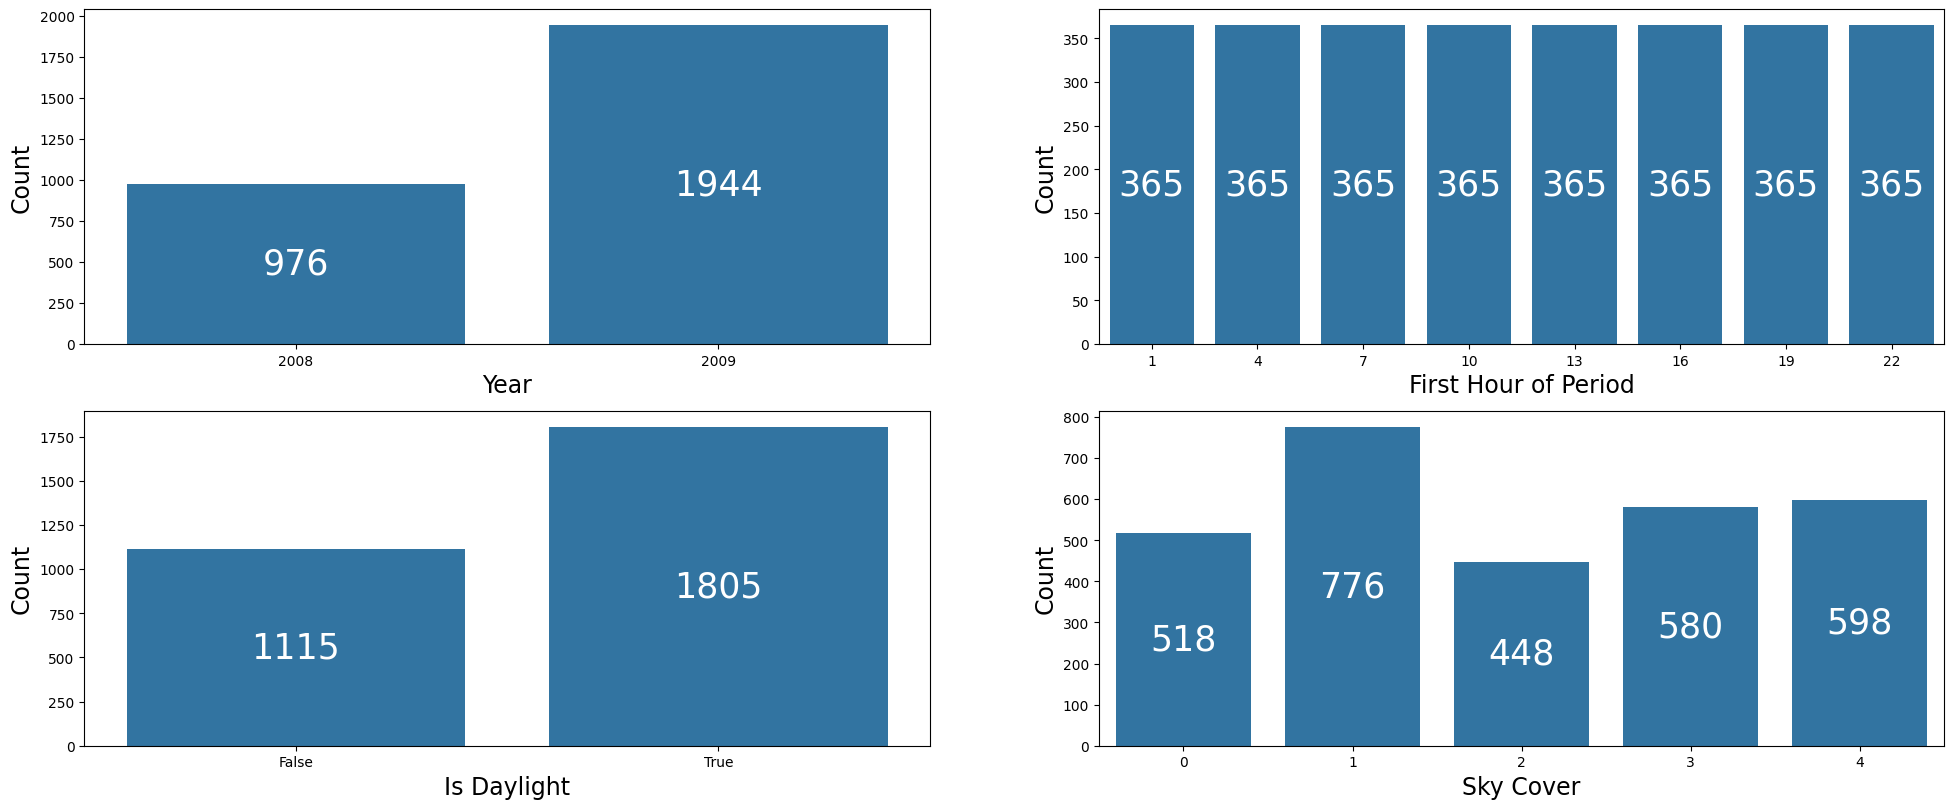

In [ ]:
plt.figure(figsize=(24,20))
#Histogram for features as Bool and Category
columns=data.columns
index=1
for col in columns:
    if (data[col].dtype=="bool" or data[col].dtype=="category"):
        plt.subplot(4, 2, index)
        hist=sns.countplot(x=data[col])  # Seaborn countplot histogram graph
        plt.xlabel(col, fontsize=17)  # Set x-axis label font size
        plt.ylabel('Count', fontsize=17)
        #To put the label to the center of the boxes
        for p in hist.patches:
            hist.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()/2.),
                        ha='center', va='center', fontsize=25, color='white')
        #plt.title(col)
        index+=1


This part covers the Distribution of the "power generation" of all dataset. This is our target and to examine of the frequency, I am using the histogram plot. It shows me that the most highest power generation is approximately 714kw demonstrated below.

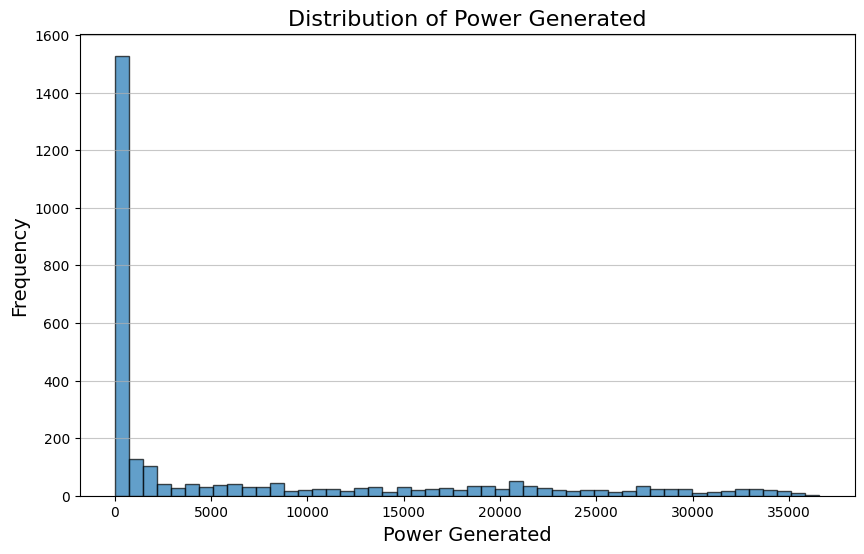

In [ ]:
#Target Distribution
#-------------------------------------------------------------------------------
# Distribution plot for 'Power Generated'
plt.figure(figsize=(10, 6))
plt.hist(data['Power Generated'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Power Generated', fontsize=16)
plt.xlabel('Power Generated', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.show()

This part covers pairplot analyse.

**General Structure:**

**Diagonal Line Graphs:**

These graphs show the distribution of each variable.

**For example:**

The histogram in the "Power Generated" column shows that most of the data is concentrated in the lower production values.

For variables such as temperature, the distribution appears more balanced.

**Off-Diagonal Graphs:**

These are scatter plots that show the relationship (correlation) between two variables.
Each cell visualizes how the two variables are related to each other.

--------
After that, I chose some variables that I thought to be effective for power generations and examine those relations specificaly

In [ ]:
# Scatter plots to analyze relationships with variables
"""
# The variables I chose are environmental or system factors that are thought to have an impact on the target variable "Power Generated" and that can
# generally be physically meaningfully related to.
"""


variables_to_plot = ['Average Temperature (Day)', 'Average Wind Speed (Day)',
                     'Sky Cover', 'Relative Humidity', 'Distance to Solar Noon'] #those are the variables that I chose

# Pairplot visualization
sns.pairplot(data, diag_kind='kde', corner=True, plot_kws={'alpha': 0.6})
"""
#To create a pairplot is requested from sns lib. This method needs some parameter such as my dataset, diag_kind determines the type of graphs on the diagonal
alpha is for the transparency and corner=True enables display of the lower triangle (removes unnecessary duplicate information).

"""
plt.suptitle('Relationships Between Power Generated and Key Variables', y=1.02, fontsize=16)
plt.show()



for var in variables_to_plot: #This loop iterates through each variable in the `variables_to_plot` list.
    plt.figure(figsize=(8, 5)) #Create a base figure
    plt.scatter(data[var], data['Power Generated'], alpha=0.5) #create a scatter on figure
    plt.title(f'Power Generated vs {var}', fontsize=14) # title and fontsize
    plt.xlabel(var, fontsize=12) #x label for every var variable
    plt.ylabel('Power Generated', fontsize=12) # y label is constant as "Power Generated"
    plt.grid(alpha=0.3) # grid for better readable plots
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

Then Correlation matrix shows that the correlations of each numeric variables.

**For example:**

Negative Correlation:Between "Distance to Solar noon" and "power generation" have -0.75 correlation and this is a "Strong Negative Correlation" which means as proximity to the sun decreases, energy production decreases. This is to be expected, because solar panels produce the most energy at noon.

Positive Correlation: Between "Average Wind Speed (Period)" and "power generation" have 0.28 correlation and this is a "Positive Correlation" though not strong which means temperature does not appear to have a significant effect on energy production.

----------

After datapreprocessing, explanation of the correlation is at the following parts.


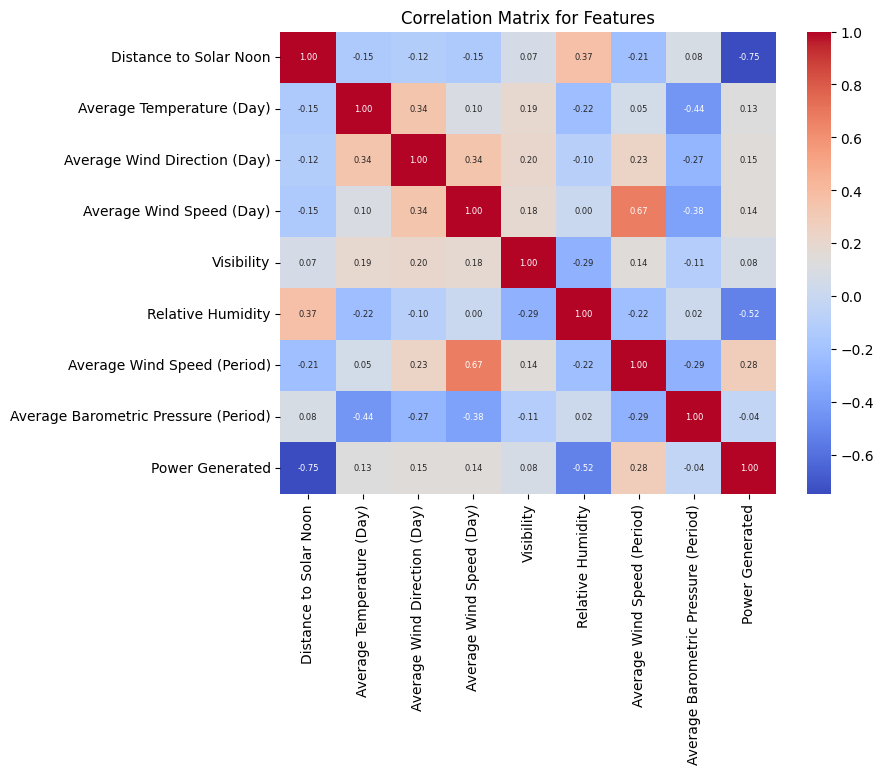

In [ ]:
#Correlation between numeric values
data_corr=data.copy() # Create a copy to avoid modifying the original DataFrame
# Check if the columns exist before dropping
columns_to_drop = ['Year', 'Month', 'Day','Day of Year','Is Daylight', 'Sky Cover', 'Year', 'First Hour of Period']
existing_columns = [col for col in columns_to_drop if col in data_corr.columns] #Fill the Existing_columns variable by a for loop

#
data_corr.drop(existing_columns, axis=1, inplace=True) # Drop only existing categorical columns
correlation_matrix = data_corr.corr() #Create the correlation matrix of the data_corr which is we prepared for matrix.
plt.figure(figsize=(8, 6)) #create the figure we wiill draw on that
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"fontsize": 6}) #add and heat map on that
plt.title("Correlation Matrix for Features")#set a title
plt.show()#and finaly show it


To check details from a table, I also print it as string

In [ ]:
print(correlation_matrix)

                                      Distance to Solar Noon  \
Distance to Solar Noon                              1.000000   
Average Temperature (Day)                          -0.145207   
Average Wind Direction (Day)                       -0.118010   
Average Wind Speed (Day)                           -0.145073   
Visibility                                          0.065807   
Relative Humidity                                   0.368964   
Average Wind Speed (Period)                        -0.214887   
Average Barometric Pressure (Period)                0.082505   
Power Generated                                    -0.746681   

                                      Average Temperature (Day)  \
Distance to Solar Noon                                -0.145207   
Average Temperature (Day)                              1.000000   
Average Wind Direction (Day)                           0.342146   
Average Wind Speed (Day)                               0.096267   
Visibility              

Before change and preprocess data, I wonder that the Power Generation changes for all these two years and this seems meaningful also.
I also checked the outliers and seeing too many outlier value on my dataset. After analyse correlation matrix, we will see that weather these outlier values are valid. Should we keep them or not.

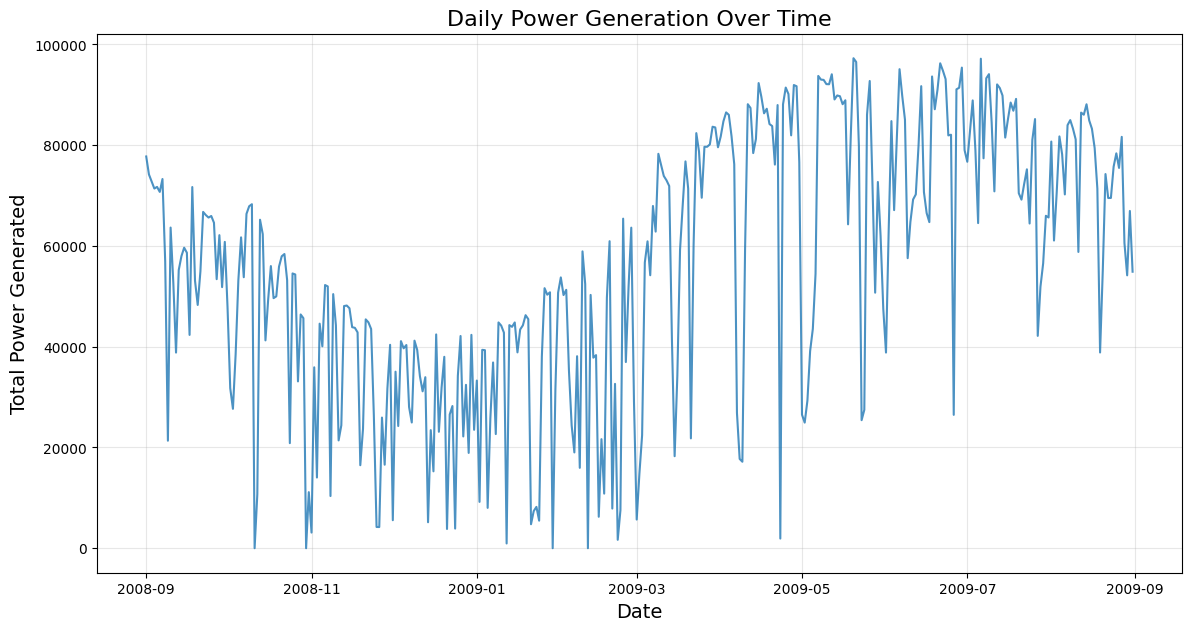

Text(0, 0.5, 'Power Generated')

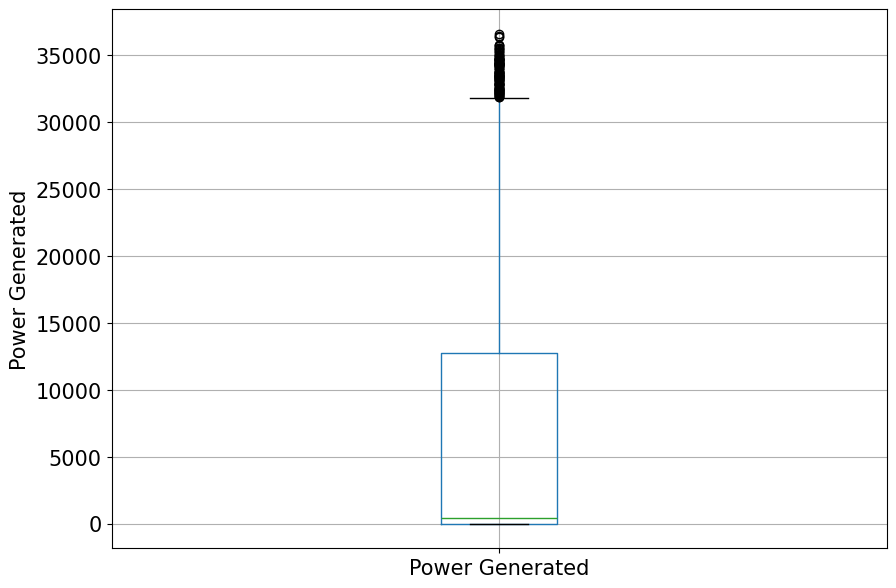

In [ ]:
# Create a new column for a combined date (if needed)
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']]) #Combine seperated data features and create new one.

# Group data by 'Date' and calculate the total power generated each day
daily_power = data.groupby('Date')['Power Generated'].sum()

# Plot the daily power generation over time
plt.figure(figsize=(14, 7))
plt.plot(daily_power.index, daily_power.values, alpha=0.8)
plt.title('Daily Power Generation Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Power Generated', fontsize=14)
plt.grid(alpha=0.3)
plt.show()


plt.figure(figsize=(10,7))
fig = data.boxplot(column='Power Generated',fontsize=15) #create a box plot to see the outliers on target value
fig.set_ylabel('Power Generated',fontsize=15)


Till this part, It was about exploration of dataset. Now, I am starting to think about how can I create more features and how should I change the existed values. Preprocessing is started on this part. I am copying the dataset to df because if I have an issue on the code, I don't want to compile from the begining.

In [ ]:
df = data.copy()
df.head()

,Day of Year,Year,Month,Day,First Hour of Period,Is Daylight,Distance to Solar Noon,Average Temperature (Day),Average Wind Direction (Day),Average Wind Speed (Day),Sky Cover,Visibility,Relative Humidity,Average Wind Speed (Period),Average Barometric Pressure (Period),Power Generated,Date
0,245,2008,9,1,1,False,0.859897,69,28,7.5,0,10.0,75,8.0,29.82,0,2008-09-01
1,245,2008,9,1,4,False,0.628535,69,28,7.5,0,10.0,77,5.0,29.85,0,2008-09-01
2,245,2008,9,1,7,True,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418,2008-09-01
3,245,2008,9,1,10,True,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477,2008-09-01
4,245,2008,9,1,13,True,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069,2008-09-01


When looking at the dataset, I saw that I can create some new features on it such as "season feature" by using month values like summer, winter etc, "first hour of period" values can tell me "is it night or day times",I assume that sun rise is till 6am, and then I create the "solar proximity" by using the "distance to solar noon", that is a numeric value representing how far a given time is from solar noon and smaller values mean closer proximity to solar noon, while larger values mean farther away. I decided to "0.2, 0.5 and others" clusters by considering graph below.

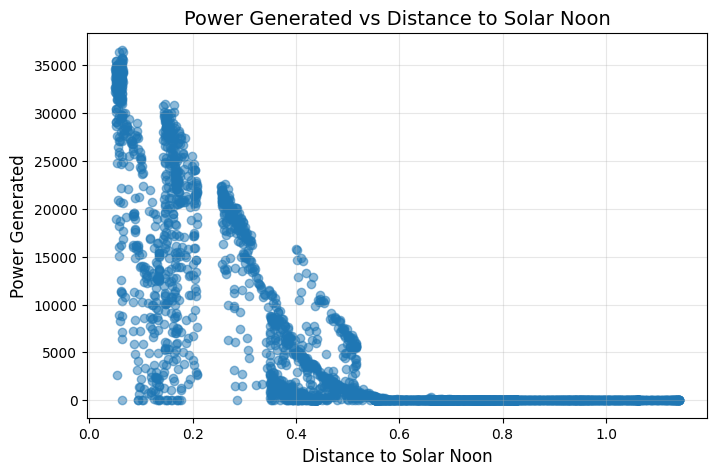

In [ ]:
#Data Preprocessing and feature Engineering
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'
#-----------------------------------------------------
def time_of_day(hour):
    if hour < 6:
        return 'Night'
    elif hour < 12:
        return 'Morning'
    elif hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'
#-------------------------------------------------------
def solar_proximity(distance):
    if distance < 0.2:
        return 'Near Noon'
    elif distance < 0.5:
        return 'Midday'
    else:
        return 'Far from Noon'


df["is daylight"]=df["is daylight"].apply(lambda x: 1 if x==True else 0)#Change 'is daylight' column with 1/0 values to prepare for model
df["is daylight"]=df["is daylight"].astype("bool")

#Feature Engineer (Create new features or delete unnecessary)
df['season'] = df['month'].apply(get_season) #create season feature from month value
df['time of day'] = df['first hour of period'].apply(time_of_day)
df['solar proximity'] = df['distance to solar noon'].apply(solar_proximity)


#one-hot encoding
df = pd.get_dummies(df, columns=['season', 'time of day', 'solar proximity','sky cover'], drop_first=True) #turn these columns' clusters into the columns typed as bool



# remove unecessary columns because we created a new column by integrated them (Year, Month, Day, Day of Year)
columns_to_drop = ['year', 'month', 'day', 'day of year','first hour of period']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)


print("\nOriginal Column Names:")
print(df.columns.tolist())

df.columns = df.columns.str.strip().str.lower()
print("\nColumn Names after standardization:")
print(df.columns.tolist())

df.head()



Original Column Names:
['Day of Year', 'Year', 'Month', 'Day', 'First Hour of Period', 'Is Daylight', 'Distance to Solar Noon', 'Average Temperature (Day)', 'Average Wind Direction (Day)', 'Average Wind Speed (Day)', 'Sky Cover', 'Visibility', 'Relative Humidity', 'Average Wind Speed (Period)', 'Average Barometric Pressure (Period)', 'Power Generated', 'Date']

Column Names after standardization:
['day of year', 'year', 'month', 'day', 'first hour of period', 'is daylight', 'distance to solar noon', 'average temperature (day)', 'average wind direction (day)', 'average wind speed (day)', 'sky cover', 'visibility', 'relative humidity', 'average wind speed (period)', 'average barometric pressure (period)', 'power generated', 'date']


,is daylight,distance to solar noon,average temperature (day),average wind direction (day),average wind speed (day),visibility,relative humidity,average wind speed (period),average barometric pressure (period),power generated,...,season_Winter,time of day_Evening,time of day_Morning,time of day_Night,solar proximity_Midday,solar proximity_Near Noon,sky cover_1,sky cover_2,sky cover_3,sky cover_4
0,False,0.859897,69,28,7.5,10.0,75,8.0,29.82,0,...,False,False,False,True,False,False,False,False,False,False
1,False,0.628535,69,28,7.5,10.0,77,5.0,29.85,0,...,False,False,False,True,False,False,False,False,False,False
2,True,0.397172,69,28,7.5,10.0,70,0.0,29.89,5418,...,False,False,True,False,True,False,False,False,False,False
3,True,0.165810,69,28,7.5,10.0,33,0.0,29.91,25477,...,False,False,True,False,False,True,False,False,False,False
4,True,0.065553,69,28,7.5,10.0,21,3.0,29.89,30069,...,False,False,False,False,False,True,False,False,False,False


**When we look at the correlations which are related to target value :**

**Distance to Solar Noon (-0.75):**

-Strong negative correlation.

-Energy production decreases as proximity to the sun decreases. This is expected, since solar panels produce the most energy at noon.

**Relative Humidity (-0.52):**

-Moderate negative correlation.

-Energy production may decrease as humidity increases. This may be due to humidity being associated with cloudy weather.

**Average Wind Speed ​​(Period) (0.28):**

-Weak positive correlation.

-An increase in wind speed may slightly increase energy production, but the relationship is quite weak.

**Average Temperature (Day) (0.13):**

-Very weak positive correlation.

-Temperature does not appear to have a significant effect on energy production.


---------------------


**Relationships Between Variables**

**Average Wind Speed ​​(Day) and Average Wind Speed ​​(Period) (0.67):**

-Strong positive relationship.

-There is a direct relationship between these two variables because they both represent wind speed.

**Relative Humidity and Distance to Solar Noon (0.37):**

-Weak positive relationship.

-Humidity may be slightly related to the position of the sun.

**Average Barometric Pressure (Period) and Relative Humidity (-0.52):**

-Moderate negative relationship.

-Air pressure and humidity are generally inversely related.


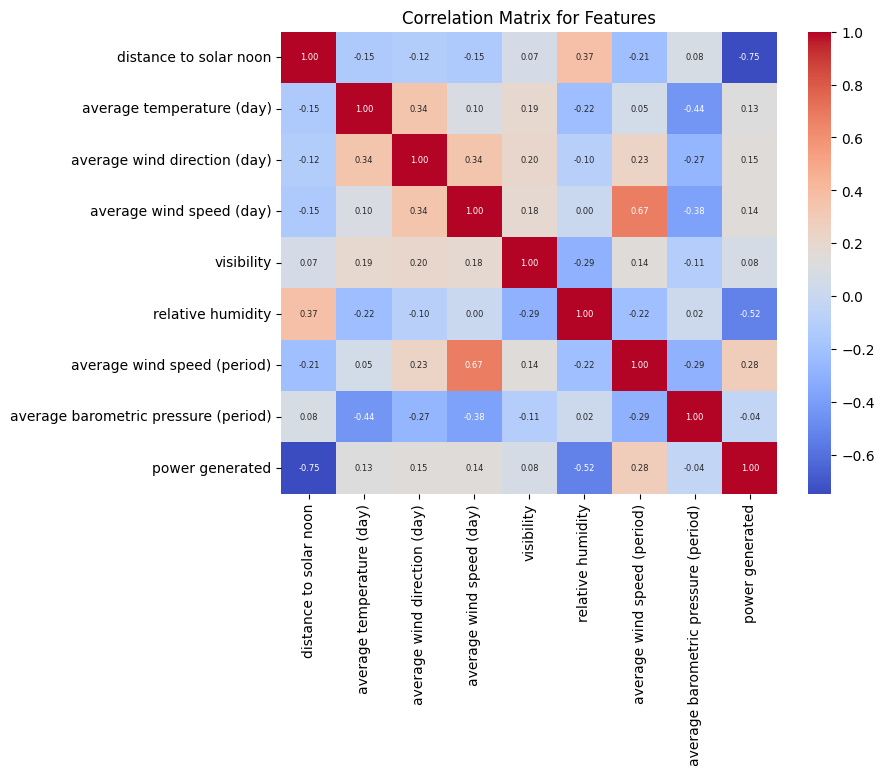

In [ ]:
#Check the correlation again for only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"fontsize": 6})
plt.title("Correlation Matrix for Features")
plt.show()



Assign Dependent and Independent Variables

In [ ]:
X = df.drop(['power generated','date'], axis=1)  # 'Power Generated' dependent variable so X covers independent variables without dependent variables
y = df['power generated']  # y is dependent variable

This part covers the initial part of prediction how is started with split data test and training.

I am printing X_train data types. I wanted to see the training data types one last time to make sure.

In [ ]:
# Split as Train and Test variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #0.8 is train and 0.2 is for test , random_state is 42 as any value
print(X_train.dtypes)

is daylight                                bool
distance to solar noon                  float64
average temperature (day)                 int64
average wind direction (day)              int64
average wind speed (day)                float64
visibility                              float64
relative humidity                         int64
average wind speed (period)             float64
average barometric pressure (period)    float64
season_Spring                              bool
season_Summer                              bool
season_Winter                              bool
time of day_Evening                        bool
time of day_Morning                        bool
time of day_Night                          bool
solar proximity_Midday                     bool
solar proximity_Near Noon                  bool
sky cover_1                                bool
sky cover_2                                bool
sky cover_3                                bool
sky cover_4                             

In [ ]:
# Standardization of Numeric Variables
scaler = StandardScaler() #create the scaler by using StandartScaler method from sklearn lib
X_train = scaler.fit_transform(X_train) # Scales the training data (X_train).
X_test = scaler.transform(X_test)# Scales the test data.


The Prediction model that I used is "Random Forest Regressor", I chose that because:
1. Random Forest is an ensemble learning method that combines the predictions of multiple decision trees to improve accuracy and reduce overfitting.
2. It is particularly effective when dealing with non-linear relationships in the data, as it can capture complex patterns.



**There are 2 metrics to interpret outputs**

**MSE:**

-Useful to understand the magnitude of errors.

-However, looking at MSE alone is not enough because this value varies with the magnitude of the target variable.

**R²:**

-Useful to understand how well the model explains the target variable.

-Since it is dimensionless, it is more useful for comparing different models.


In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)# A Random Forest model with 100 trees is created.
# random_state=42 provides randomness control to ensure repeatability of results.
rf_model.fit(X_train, y_train)# The model is trained using the training data (X_train, y_train).

# Prediction on Test Data
y_pred = rf_model.predict(X_test) # After training, the model makes predictions on the test data (X_test).


mse = mean_squared_error(y_test, y_pred) # Mean Squared Error (MSE) is calculated.
r2 = r2_score(y_test, y_pred) # The R^2 score is calculated. This shows the explanatory power of the model.
print(f"Mean Squared Error: {mse}") #The R^2 score is calculated. This shows the explanatory power of the model.
print(f"R^2 Score: {r2}") #print the metrics

Mean Squared Error: 10776163.010604452
R^2 Score: 0.8976983239754858


To see comparing of the estimation, I am creating the scatter plot. This plot shows me that comparing of real and estimated values. If real values match predictions totaly, I would see an exact diagonal line.

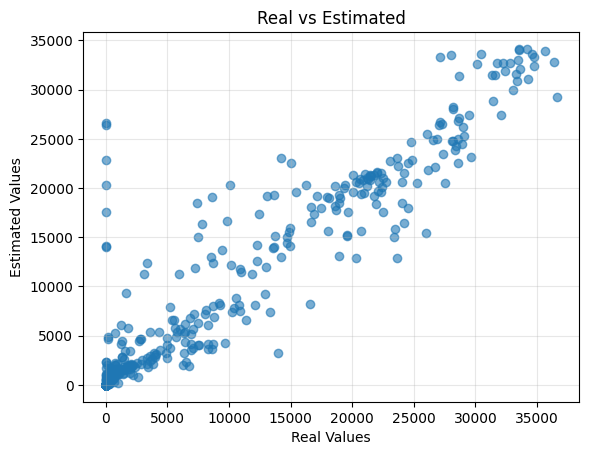

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Real Values")
plt.ylabel("Estimated Values")
plt.title("Real vs Estimated")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Specify hyperparameter search ranges
param_grid = {
    'n_estimators': [50, 100, 200],              # Tree count
    'max_depth': [None, 10, 20, 30],             # Max Depth
    'min_samples_split': [2, 5, 10],             # Minimum instance for branching
    'min_samples_leaf': [1, 2, 4],               # Minimum sample on each leaf
    'max_features': ['sqrt', 'log2'],    # Feature selection strategy
}

# GridSearchCV for RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)                       # The Random Forest model is optimized with Grid Search.
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,   # param_grid: Specifies the parameter ranges to optimize the model's hyperparameters.
                           scoring='r2', cv=5, verbose=2, n_jobs=-1)    # The performance of the model is evaluated using the 'r2' metric.
                                                                        # 5-fold cross-validation is applied.
                                                                        # Progress outputs are provided during operation.
                                                                        # n_jobs=-1: It speeds up the process by using all the processor cores.
# Model training with GridSearchCV
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Estimate by Optimum model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Performance evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error: 9884502.312705677
R^2 Score: 0.9061631535953113


After GridSearchCV method, R^2 score increased, and when looking at the char below, we can see tiny changes according to previous chart. 91% R^2 score is great score and the magnitude of the MSE is due to the scale of the target variable. We know that our target variable varies over a wide range (from 0 to 36,580). Therefore, it is normal for the MSE to be large.

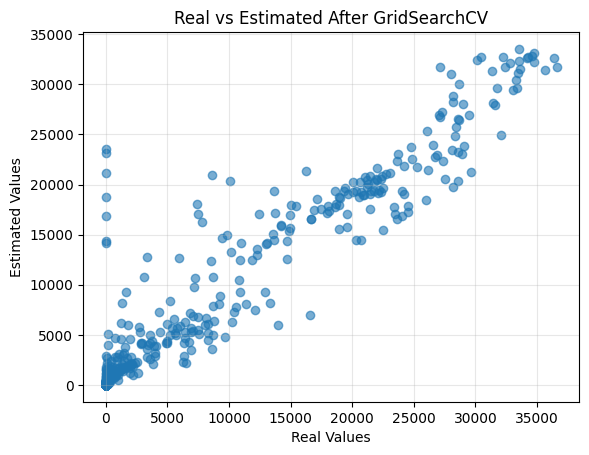

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Real Values")
plt.ylabel("Estimated Values")
plt.title("Real vs Estimated After GridSearchCV")
plt.grid(alpha=0.3)
plt.show()